# **Breast Cancer Wisconsin**

https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

## **1. Chuẩn bị dữ liệu**

- Import các thư viện cần thiết:

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

- Config:

In [2]:
class CONFIG:
    # Giá trị ngẫu nhiên
    random_state = None

    # Tỷ lệ chia tập dữ liệu
    split_ratios = {
        '40/60': 0.4,
        '60/40': 0.6,
        '80/20': 0.8,
        '90/10': 0.9
    }

    # Giá trị mặc định để kiểm tra độ sâu và độ chính xác
    default_split = '80/20'

    # Đường dẫn file dữ liệu gốc
    raw_data_path = "Raw/wdbc.data"

    # Thư mục lưu kết quả các phân phối
    distribution_dataset_dir = "Results/DistributedDataset"

    # Thư mục lưu kết quả cây quyết định với các tỉ lệ
    tree_visual_split_dir = "Results/TreeVisualizationsBySplit"

    # Thư mục lưu kết quả thử nghiệm max_depth cho cây quyết định
    tree_visual_max_depth_dir = "Results/TreeVisualizationsWithMaxDepth"

    # Thư mục lưu kết quả trực quan hóa
    visual_confusion_matrix_dir = "Results/VisualizationConfusionMatrix"

    # Giá trị độ sâu tối đa cho thử nghiệm cây quyết định
    max_depth_values = [None, 2, 3, 4, 5, 6, 7]

#### **1. Đọc dữ liệu**

In [3]:
class_name = 'Diagnosis'
columns = ['ID', class_name] + [f'Feature_{i}' for i in range(1, 31)]
data = pd.read_csv(CONFIG.raw_data_path, header=None, names=columns)

- Kiểm tra dữ liệu

In [4]:
# Kiểm tra thông tin dữ liệu
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          569 non-null    int64  
 1   Diagnosis   569 non-null    object 
 2   Feature_1   569 non-null    float64
 3   Feature_2   569 non-null    float64
 4   Feature_3   569 non-null    float64
 5   Feature_4   569 non-null    float64
 6   Feature_5   569 non-null    float64
 7   Feature_6   569 non-null    float64
 8   Feature_7   569 non-null    float64
 9   Feature_8   569 non-null    float64
 10  Feature_9   569 non-null    float64
 11  Feature_10  569 non-null    float64
 12  Feature_11  569 non-null    float64
 13  Feature_12  569 non-null    float64
 14  Feature_13  569 non-null    float64
 15  Feature_14  569 non-null    float64
 16  Feature_15  569 non-null    float64
 17  Feature_16  569 non-null    float64
 18  Feature_17  569 non-null    float64
 19  Feature_18  569 non-null    f

In [5]:
# Kiểm tra sơ bộ
print(data.head())

         ID Diagnosis  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0    842302         M      17.99      10.38     122.80     1001.0    0.11840   
1    842517         M      20.57      17.77     132.90     1326.0    0.08474   
2  84300903         M      19.69      21.25     130.00     1203.0    0.10960   
3  84348301         M      11.42      20.38      77.58      386.1    0.14250   
4  84358402         M      20.29      14.34     135.10     1297.0    0.10030   

   Feature_6  Feature_7  Feature_8  ...  Feature_21  Feature_22  Feature_23  \
0    0.27760     0.3001    0.14710  ...       25.38       17.33      184.60   
1    0.07864     0.0869    0.07017  ...       24.99       23.41      158.80   
2    0.15990     0.1974    0.12790  ...       23.57       25.53      152.50   
3    0.28390     0.2414    0.10520  ...       14.91       26.50       98.87   
4    0.13280     0.1980    0.10430  ...       22.54       16.67      152.20   

   Feature_24  Feature_25  Feature_26  Featu

In [6]:
# Kiểm tra giá trị duy nhất trong nhãn:
print(data[class_name].value_counts())

Diagnosis
B    357
M    212
Name: count, dtype: int64


In [7]:
# Kiểm tra thống kê dữ liệu:
print(data.describe())

                 ID   Feature_1   Feature_2   Feature_3    Feature_4  \
count  5.690000e+02  569.000000  569.000000  569.000000   569.000000   
mean   3.037183e+07   14.127292   19.289649   91.969033   654.889104   
std    1.250206e+08    3.524049    4.301036   24.298981   351.914129   
min    8.670000e+03    6.981000    9.710000   43.790000   143.500000   
25%    8.692180e+05   11.700000   16.170000   75.170000   420.300000   
50%    9.060240e+05   13.370000   18.840000   86.240000   551.100000   
75%    8.813129e+06   15.780000   21.800000  104.100000   782.700000   
max    9.113205e+08   28.110000   39.280000  188.500000  2501.000000   

        Feature_5   Feature_6   Feature_7   Feature_8   Feature_9  ...  \
count  569.000000  569.000000  569.000000  569.000000  569.000000  ...   
mean     0.096360    0.104341    0.088799    0.048919    0.181162  ...   
std      0.014064    0.052813    0.079720    0.038803    0.027414  ...   
min      0.052630    0.019380    0.000000    0.000000  

#### **2. Tiền xử lý dữ liệu**

- Loại bỏ cột không cần thiết

In [8]:
data = data.drop(columns=['ID'])

- Mã hóa cột **class**

In [9]:
# Mã hóa cột class
encoder = LabelEncoder()
data[class_name] = encoder.fit_transform(data[class_name])

# Thứ tự các nhãn để trực quan hóa
class_order = encoder.classes_

- Xáo trộn dữ liệu

In [10]:
data = shuffle(data, random_state=CONFIG.random_state)

- Tách nhãn và đặc trưng

In [11]:
# Đặc trưng
X = data.drop(columns=[class_name])  

# Nhãn
y = data[class_name]

#### **3. Phân chia dữ liệu với các tỷ lệ khác nhau**

In [12]:
datasets = {}
for split_name, train_ratio in CONFIG.split_ratios.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_ratio, stratify=y, random_state=CONFIG.random_state
    )
    datasets[split_name] = {
        'feature_train': X_train,
        'label_train': y_train,
        'feature_test': X_test,
        'label_test': y_test,
    }

#### **4. Hình dung phân phối nhãn**

In [13]:
def plot_label_distribution(y, title, img_path):
    y_decoded = encoder.inverse_transform(y)
    sns.countplot(x=y_decoded,order=class_order)
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()
    plt.savefig(img_path)
    print(f"* save as {img_path}")

- Phân phối dữ liệu gốc


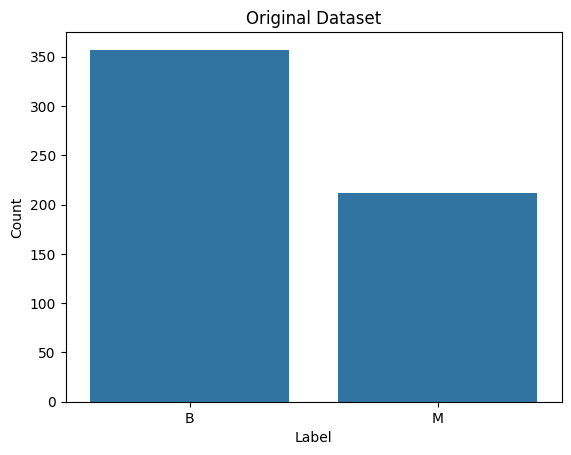

* save as Results/DistributedDataset/origin.png


<Figure size 640x480 with 0 Axes>

In [14]:
img_path = f"{CONFIG.distribution_dataset_dir}/origin.png"
plot_label_distribution(y, 'Original Dataset',img_path)

- Phân phối các tập con

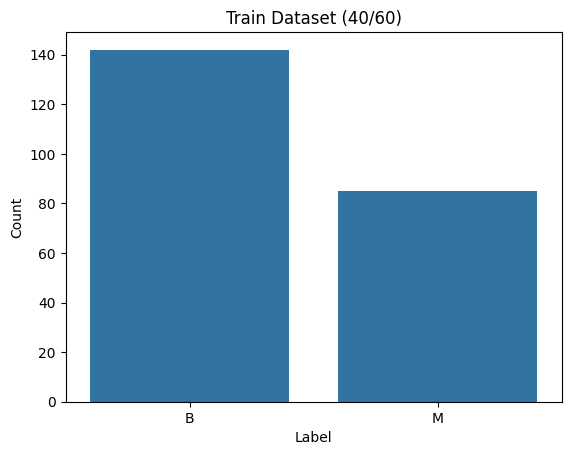

* save as Results/DistributedDataset/40_60_train.png


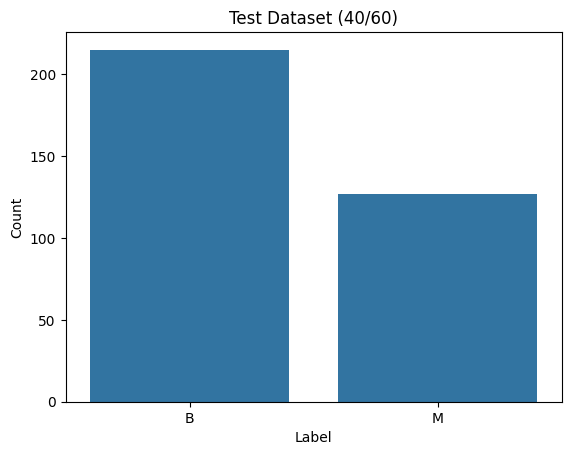

* save as Results/DistributedDataset/40_60_test.png


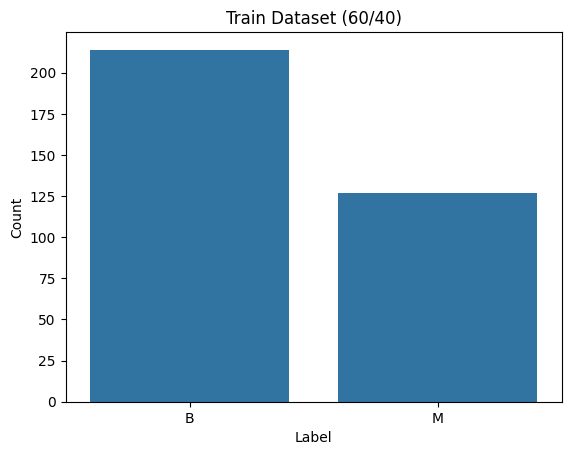

* save as Results/DistributedDataset/60_40_train.png


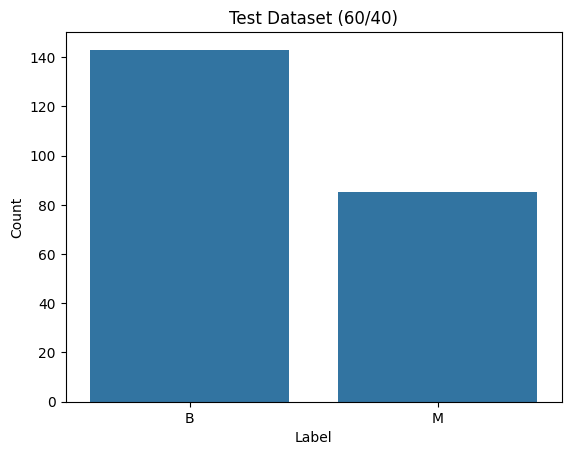

* save as Results/DistributedDataset/60_40_test.png


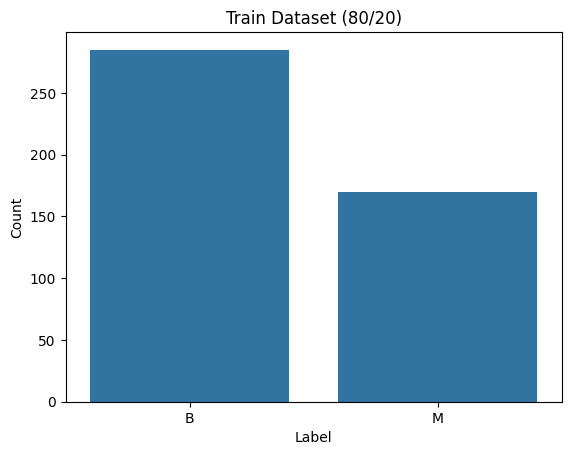

* save as Results/DistributedDataset/80_20_train.png


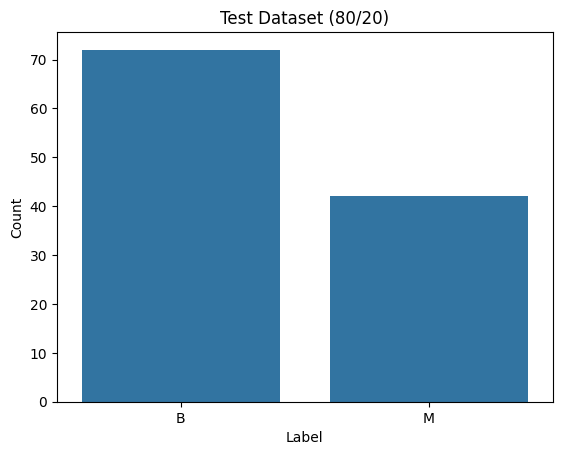

* save as Results/DistributedDataset/80_20_test.png


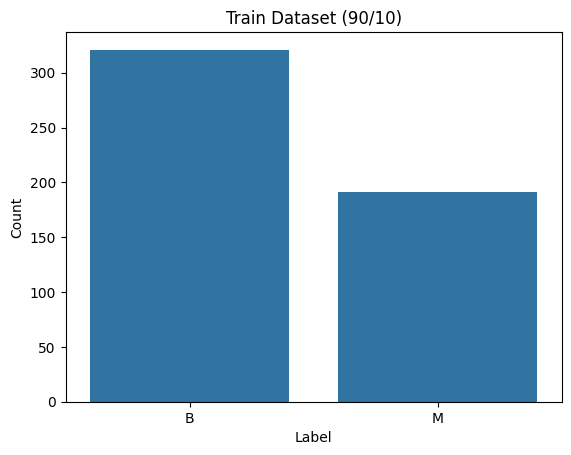

* save as Results/DistributedDataset/90_10_train.png


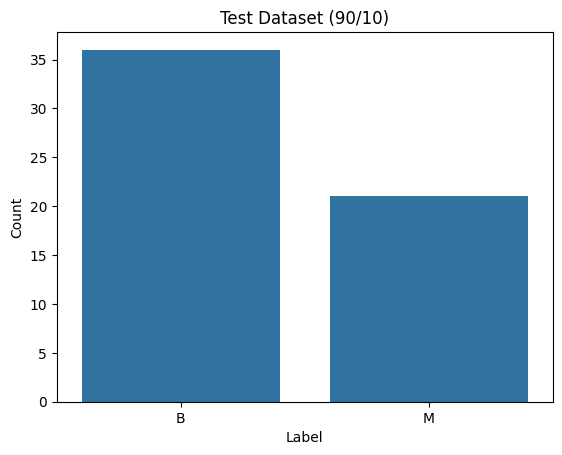

* save as Results/DistributedDataset/90_10_test.png


<Figure size 640x480 with 0 Axes>

In [15]:
for split_name, dataset in datasets.items():
    dir_path = f"{CONFIG.distribution_dataset_dir}/{split_name.replace('/','_')}"
    plot_label_distribution(dataset['label_train'], f'Train Dataset ({split_name})', f'{dir_path}_train.png')
    plot_label_distribution(dataset['label_test'], f'Test Dataset ({split_name})', f'{dir_path}_test.png')

## **2. Xây dựng bộ phân loại**

In [16]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, accuracy_score
import graphviz

- Hàm huấn luyện và trực quan hóa cây quyết định

In [17]:
def train_and_visualize(features_train, labels_train, features_test, labels_test, split_name):
    # Huấn luyện cây quyết định
    model = DecisionTreeClassifier(criterion='entropy', random_state=CONFIG.random_state)
    model.fit(features_train, labels_train)
    
    # Dự đoán trên tập kiểm tra
    predictions = model.predict(features_test)
    accuracy = accuracy_score(labels_test, predictions)
    
    # Giải mã để xem báo cáo
    labels_test_decoded = encoder.inverse_transform(labels_test)
    predictions_decoded = encoder.inverse_transform(predictions)

    # Dự đoán và đánh giá mô hình
    print(f"Results for split {split_name}")
    print("- Classification Report:")
    print(classification_report(labels_test_decoded, predictions_decoded))

    print(f"- Accuracy: {accuracy:.6f}")
    
    # Trực quan hóa cây quyết định
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=features_train.columns,
        class_names=class_order,
        filled=True, rounded=True, special_characters=True
    )
    graph = graphviz.Source(dot_data)
    filepath = f"{CONFIG.tree_visual_split_dir}/{split_name.replace('/', '_')}"
    graph.render(filepath, format="pdf")
    # graph.view()  # Mở cây trực tiếp
    # display(graph)
    print(f"- Saved tree visualization for {filepath}.pdf")
    print("------------------------------------------\n")

- Huấn luyện và lưu cây cho từng tập con

In [18]:
for split_name, dataset in datasets.items():
    train_and_visualize(
        features_train=dataset['feature_train'],
        labels_train=dataset['label_train'],
        features_test=dataset['feature_test'],
        labels_test=dataset['label_test'],
        split_name=split_name
    )

Results for split 40/60
- Classification Report:
              precision    recall  f1-score   support

           B       0.93      0.91      0.92       215
           M       0.85      0.89      0.87       127

    accuracy                           0.90       342
   macro avg       0.89      0.90      0.89       342
weighted avg       0.90      0.90      0.90       342

- Accuracy: 0.900585
- Saved tree visualization for Results/TreeVisualizationsBySplit/40_60.pdf
------------------------------------------

Results for split 60/40
- Classification Report:
              precision    recall  f1-score   support

           B       0.94      0.94      0.94       143
           M       0.89      0.89      0.89        85

    accuracy                           0.92       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.92      0.92      0.92       228

- Accuracy: 0.921053
- Saved tree visualization for Results/TreeVisualizationsBySplit/60_40.pdf
------------

## **3. Đánh giá các bộ phân loại**

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

- Hàm đánh giá mô hình và tạo báo cáo

In [20]:
def evaluate_model(features_test, labels_test, model, split_name):
    # Dự đoán trên tập kiểm tra
    predictions = model.predict(features_test)

    # Chuyển ngược về nhãn
    labels_test_decoded = encoder.inverse_transform(labels_test)
    predictions_decoded = encoder.inverse_transform(predictions)
    
    # Classification Report
    print("------------------------------------------\n")
    print(f"- Classification Report for split {split_name}")
    print(classification_report(labels_test_decoded, predictions_decoded))

    # Confusion Matrix
    cm = confusion_matrix(labels_test, predictions)
    print(f"- Confusion Matrix for split {split_name}:\n{cm}\n")
    
    # Trực quan hóa ma trận nhầm lẫn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_order, yticklabels=class_order)
    plt.title(f"Confusion Matrix for {split_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    visual_path = f"{CONFIG.visual_confusion_matrix_dir}/{split_name.replace('/', '_')}.png"
    plt.savefig(visual_path)
    print(f"- Saved as: {visual_path}")
    plt.show()

    # Trả về mô hình và độ chính xác
    accuracy = accuracy_score(labels_test, predictions)
    return accuracy

- Lặp qua từng tập con để huấn luyện, đánh giá, và lưu kết quả

------------------------------------------

- Classification Report for split 40/60
              precision    recall  f1-score   support

           B       0.93      0.91      0.92       215
           M       0.86      0.89      0.87       127

    accuracy                           0.90       342
   macro avg       0.89      0.90      0.90       342
weighted avg       0.90      0.90      0.90       342

- Confusion Matrix for split 40/60:
[[196  19]
 [ 14 113]]

- Saved as: Results/VisualizationConfusionMatrix/40_60.png


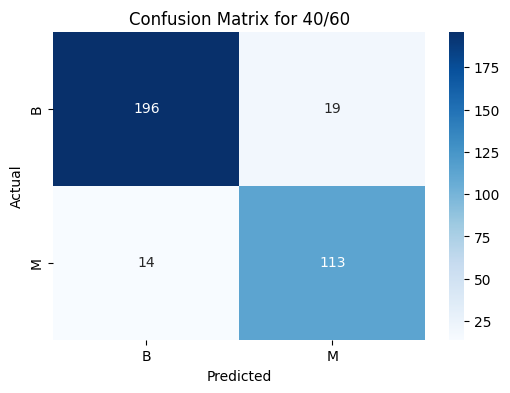

------------------------------------------

- Classification Report for split 60/40
              precision    recall  f1-score   support

           B       0.94      0.95      0.94       143
           M       0.92      0.89      0.90        85

    accuracy                           0.93       228
   macro avg       0.93      0.92      0.92       228
weighted avg       0.93      0.93      0.93       228

- Confusion Matrix for split 60/40:
[[136   7]
 [  9  76]]

- Saved as: Results/VisualizationConfusionMatrix/60_40.png


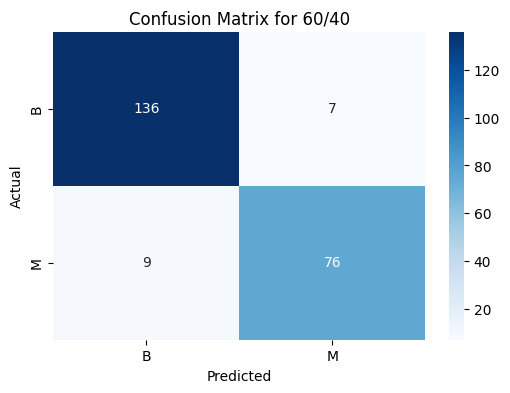

------------------------------------------

- Classification Report for split 80/20
              precision    recall  f1-score   support

           B       0.93      0.94      0.94        72
           M       0.90      0.88      0.89        42

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114

- Confusion Matrix for split 80/20:
[[68  4]
 [ 5 37]]

- Saved as: Results/VisualizationConfusionMatrix/80_20.png


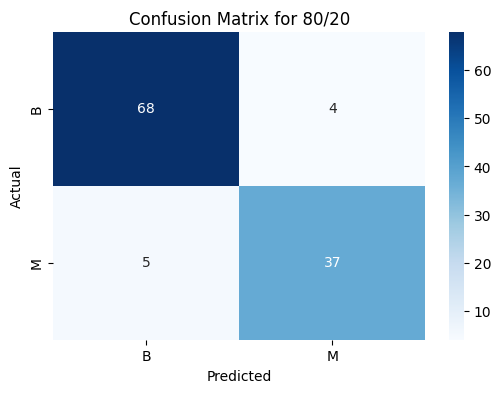

------------------------------------------

- Classification Report for split 90/10
              precision    recall  f1-score   support

           B       0.97      0.94      0.96        36
           M       0.91      0.95      0.93        21

    accuracy                           0.95        57
   macro avg       0.94      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57

- Confusion Matrix for split 90/10:
[[34  2]
 [ 1 20]]

- Saved as: Results/VisualizationConfusionMatrix/90_10.png


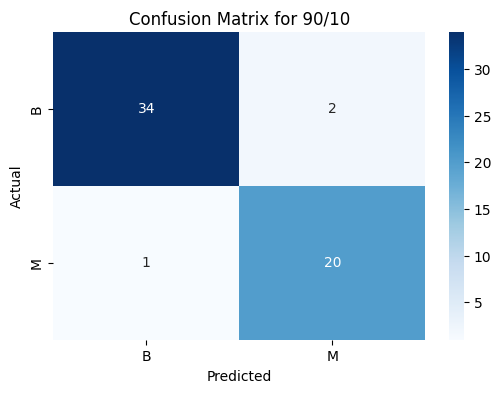

In [21]:
results = {}
for split_name, dataset in datasets.items():
    # Huấn luyện mô hình
    model = DecisionTreeClassifier(criterion='entropy', random_state=CONFIG.random_state)
    model.fit(dataset['feature_train'], dataset['label_train'])
    
    # Đánh giá mô hình
    accuracy = evaluate_model(
        features_test=dataset['feature_test'],
        labels_test=dataset['label_test'],
        model=model,
        split_name=split_name
    )
    
    # Lưu kết quả
    results[split_name] = accuracy

- Hiển thị tổng hợp kết quả độ chính xác

In [22]:
for split_name, accuracy in results.items():
    print(f"Accuracy for {split_name}: {accuracy:.6f}")

Accuracy for 40/60: 0.903509
Accuracy for 60/40: 0.929825
Accuracy for 80/20: 0.921053
Accuracy for 90/10: 0.947368


## **4. Độ sâu và độ chính xác**

- Lấy bộ dữ liệu huấn luyện và kiểm tra 80/20

In [23]:
X_train = datasets[CONFIG.default_split]['feature_train']
y_train = datasets[CONFIG.default_split]['label_train']
X_test  = datasets[CONFIG.default_split]['feature_test']
y_test  = datasets[CONFIG.default_split]['label_test']

- Thử nghiệm với các giá trị max_depth khác nhau

In [24]:
accuracy_scores = {}

for max_depth in CONFIG.max_depth_values:
    # Tạo và huấn luyện cây quyết định với max_depth
    model = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=CONFIG.random_state)
    model.fit(X_train, y_train)
    
    # Dự đoán và tính độ chính xác
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores[max_depth] = accuracy
    
    # Trực quan hóa cây quyết định
    print(f"Decision Tree with max_depth={max_depth}")
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=X_train.columns,
        class_names=encoder.classes_,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    path = f"{CONFIG.tree_visual_max_depth_dir}/{'none' if max_depth is None else max_depth}"
    graph.render(path, format="pdf")
    print(f"- Saved tree visualization for {path}.pdf")
    print("------------------------------------------\n")


Decision Tree with max_depth=None
- Saved tree visualization for Results/TreeVisualizationsWithMaxDepth/none.pdf
------------------------------------------

Decision Tree with max_depth=2
- Saved tree visualization for Results/TreeVisualizationsWithMaxDepth/2.pdf
------------------------------------------

Decision Tree with max_depth=3
- Saved tree visualization for Results/TreeVisualizationsWithMaxDepth/3.pdf
------------------------------------------

Decision Tree with max_depth=4
- Saved tree visualization for Results/TreeVisualizationsWithMaxDepth/4.pdf
------------------------------------------

Decision Tree with max_depth=5
- Saved tree visualization for Results/TreeVisualizationsWithMaxDepth/5.pdf
------------------------------------------

Decision Tree with max_depth=6
- Saved tree visualization for Results/TreeVisualizationsWithMaxDepth/6.pdf
------------------------------------------

Decision Tree with max_depth=7
- Saved tree visualization for Results/TreeVisualizations

- Hiển thị bảng kết quả

In [25]:
print("max_depth\tAccuracy")
for max_depth, accuracy in accuracy_scores.items():
    print(f"{'None' if max_depth is None else max_depth}\t\t{accuracy:.6f}")

max_depth	Accuracy
None		0.929825
2		0.912281
3		0.894737
4		0.912281
5		0.929825
6		0.929825
7		0.929825


- Vẽ biểu đồ độ chính xác

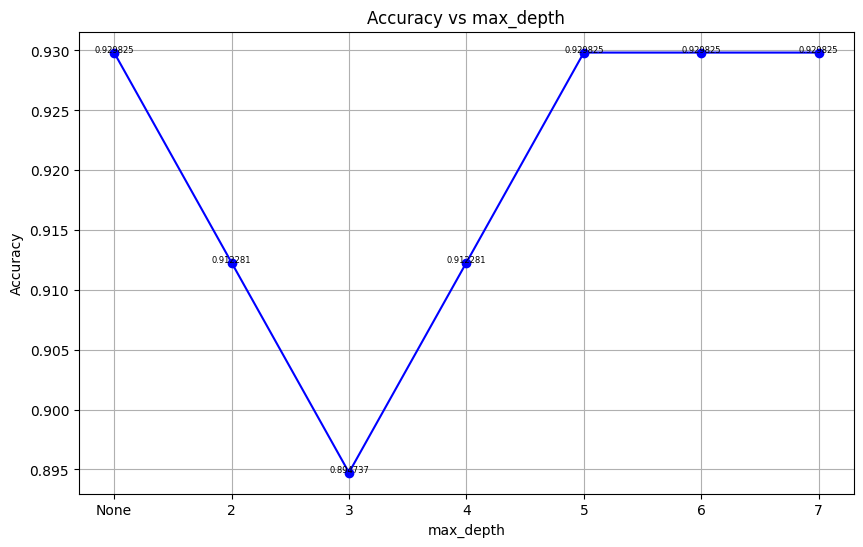

In [26]:
depth_labels = ['None' if d is None else d for d in CONFIG.max_depth_values]
accuracy_values = list(accuracy_scores.values())

plt.figure(figsize=(10, 6))
plt.plot(depth_labels, accuracy_values, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.grid(True)
for i, txt in enumerate(accuracy_values):
    plt.text(i, accuracy_values[i], f"{accuracy_values[i]:.6f}", fontsize=6, ha='center')

plt.show()
